In [1]:
import xarray as xr
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelmax, savgol_filter
from scipy.interpolate import UnivariateSpline

In [ ]:
def normalize_continuum(wavelength, flux, flux_error=None, poly_order=2, exclude_regions=None, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    if exclude_regions is not None:
        for region in exclude_regions:
            mask &= ~((wavelength > region[0]) & (wavelength < region[1]))

    # Fit polynomial to raw flux outside excluded regions
    poly_coeffs = np.polyfit(wavelength[mask], flux[mask], deg=poly_order)
    continuum = np.polyval(poly_coeffs, wavelength)

    # Normalize flux and error
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    # Compute residuals and sum of squared residuals in fit regions
    residuals = flux[mask] - continuum[mask]
    ssr = np.sum(residuals ** 2)

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label=f"Continuum (order {poly_order})", linestyle="--")
        if exclude_regions is not None:
            for region in exclude_regions:
                plt.axvspan(region[0], region[1], color='red', alpha=0.2)
        plt.legend()
        plt.title("Continuum Fit")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.show()

        plt.figure(figsize=(8,2))
        plt.plot(wavelength[mask], residuals, '.', label="Residuals")
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Residuals")
        plt.show()

    return norm_flux, norm_flux_error, continuum, mask, ssr

In [3]:
def calculate_bic(ssr, N, k):
    return N * np.log(ssr / N) + k * np.log(N)


In [4]:
def patient_select_best_poly_order_bic(wavelength, flux, flux_error=None, exclude_regions=None, max_order=8, plot=False, min_bic_improvement=1000, patience=2):
    _, _, _, mask, _ = normalize_continuum(
        wavelength, flux, flux_error=flux_error,
        poly_order=1,
        exclude_regions=exclude_regions,
        plot=False
    )
    N = np.sum(mask)

    bics = []
    orders = list(range(1, max_order + 1))

    best_order = 1
    best_bic = np.inf
    prev_bic = None
    bad_steps = 0  # counts how many consecutive steps without improvement

    for order in orders:
        _, _, _, _, ssr = normalize_continuum(
            wavelength, flux, flux_error=flux_error,
            poly_order=order,
            exclude_regions=exclude_regions,
            plot=False
        )

        k = order + 1
        bic = calculate_bic(ssr, N, k)
        bics.append(bic)

        print(f"Order {order}: BIC = {bic:.2f}")

        if bic < best_bic - min_bic_improvement:
            best_bic = bic
            best_order = order
            bad_steps = 0  # reset patience counter
        else:
            bad_steps += 1

        if bad_steps >= patience:
            print(f"Stopping early at order {order} after {patience} consecutive non-improvements.")
            break

    # Plot final continuum if requested
    if plot:
        normalize_continuum(
            wavelength, flux, flux_error=flux_error,
            poly_order=best_order,
            exclude_regions=exclude_regions,
            plot=True
        )

    print(f"Selected best polynomial order by BIC: {best_order}")

    plt.plot(orders[:len(bics)], bics, marker='o')
    plt.xlabel('Polynomial Order')
    plt.ylabel('BIC')
    plt.title('BIC vs Polynomial Order')
    plt.show()

    return best_order


Order 1: BIC = 56806.05
Order 2: BIC = 47980.70
Order 3: BIC = 47944.98
Order 4: BIC = 47841.72
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


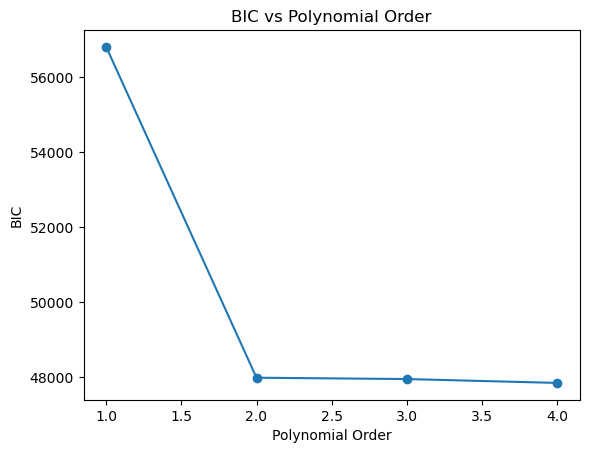

Spectrum 0: Best polynomial order = 2
Order 1: BIC = 57181.62
Order 2: BIC = 47853.88
Order 3: BIC = 47297.59
Order 4: BIC = 46891.58
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


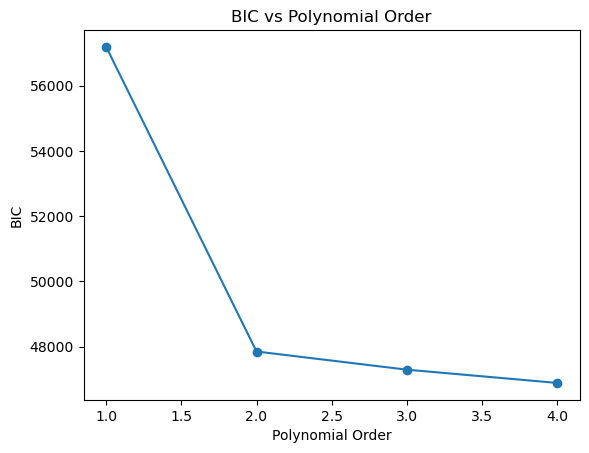

Spectrum 1: Best polynomial order = 2
Order 1: BIC = 57558.27
Order 2: BIC = 48720.91
Order 3: BIC = 48688.93
Order 4: BIC = 48583.02
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


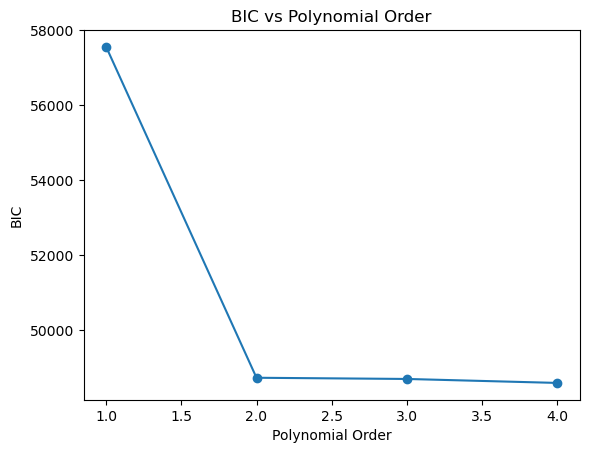

Spectrum 2: Best polynomial order = 2
Order 1: BIC = 57689.41
Order 2: BIC = 48311.96
Order 3: BIC = 47766.72
Order 4: BIC = 47395.85
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


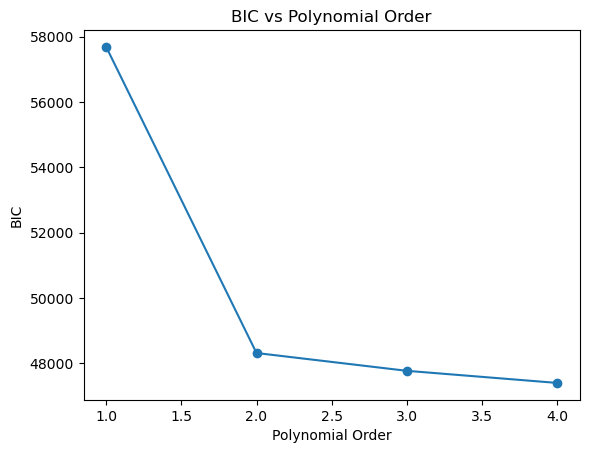

Spectrum 3: Best polynomial order = 2
Order 1: BIC = 57618.01
Order 2: BIC = 48828.91
Order 3: BIC = 48791.61
Order 4: BIC = 48693.22
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


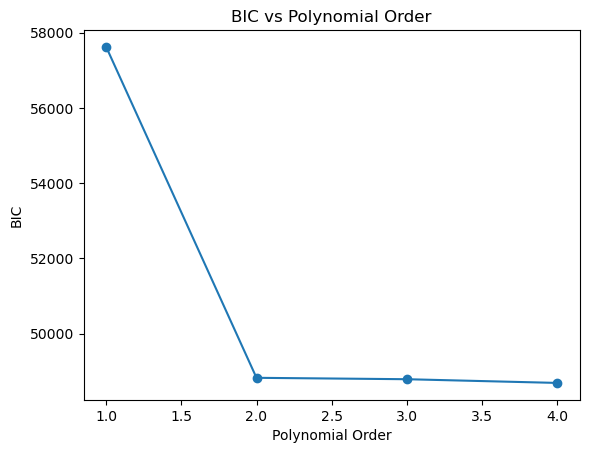

Spectrum 4: Best polynomial order = 2
Order 1: BIC = 57035.56
Order 2: BIC = 47700.39
Order 3: BIC = 47112.69
Order 4: BIC = 46782.09
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


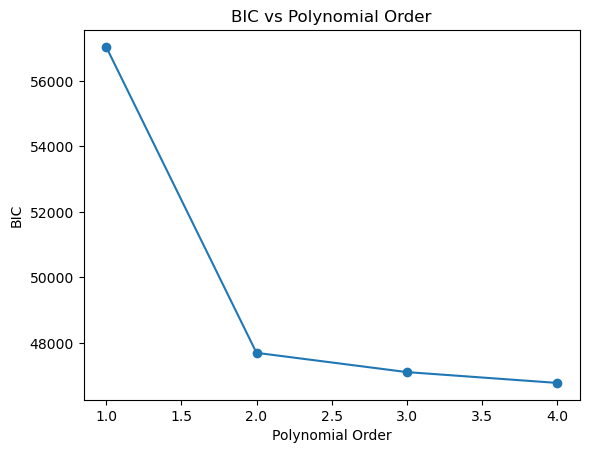

Spectrum 5: Best polynomial order = 2
Order 1: BIC = 53145.18
Order 2: BIC = 44393.67
Order 3: BIC = 44360.22
Order 4: BIC = 44266.95
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


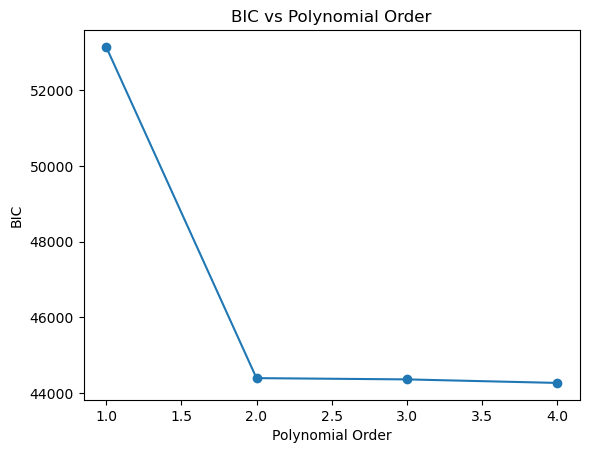

Spectrum 6: Best polynomial order = 2
Order 1: BIC = 54286.62
Order 2: BIC = 45054.29
Order 3: BIC = 44508.12
Order 4: BIC = 44174.43
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


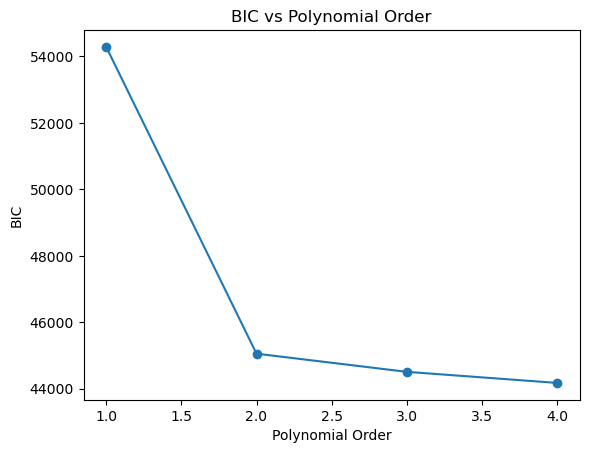

Spectrum 7: Best polynomial order = 2
Order 1: BIC = 58370.97
Order 2: BIC = 49566.76
Order 3: BIC = 49531.05
Order 4: BIC = 49429.84
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


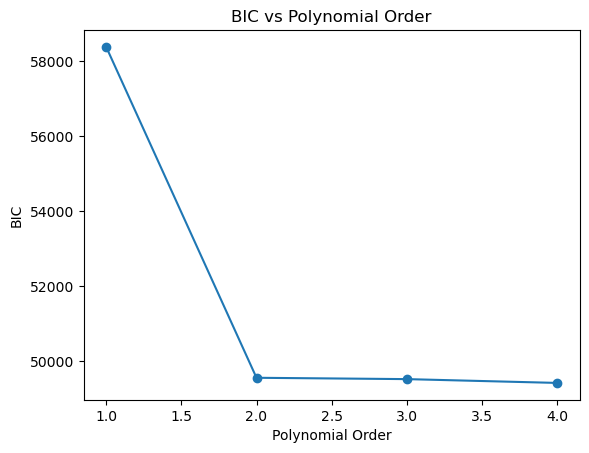

Spectrum 8: Best polynomial order = 2
Order 1: BIC = 58252.57
Order 2: BIC = 49013.20
Order 3: BIC = 48543.49
Order 4: BIC = 48215.68
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


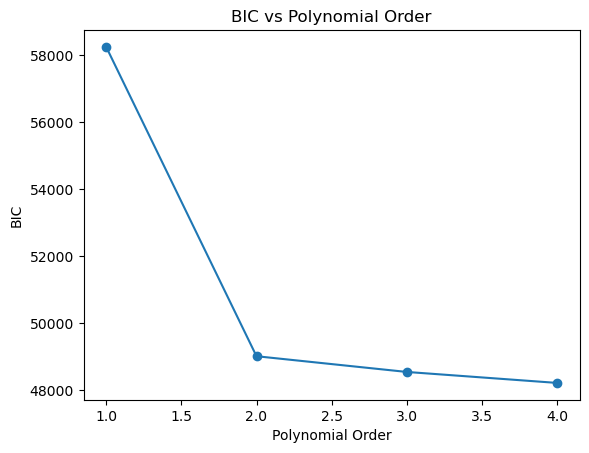

Spectrum 9: Best polynomial order = 2
Order 1: BIC = 58856.10
Order 2: BIC = 50202.23
Order 3: BIC = 50173.83
Order 4: BIC = 50074.41
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


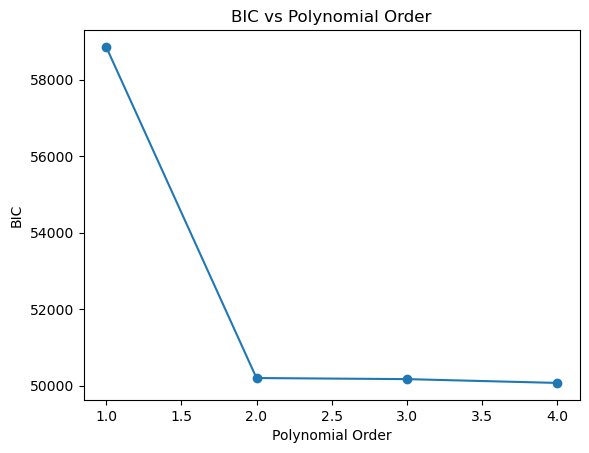

Spectrum 10: Best polynomial order = 2
Order 1: BIC = 58511.46
Order 2: BIC = 49309.24
Order 3: BIC = 48875.54
Order 4: BIC = 48544.07
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


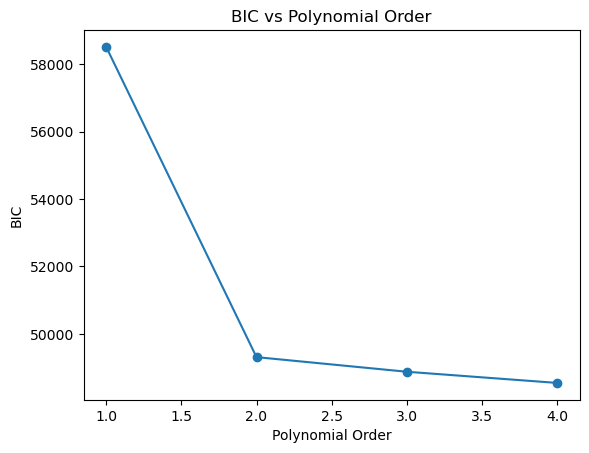

Spectrum 11: Best polynomial order = 2
Order 1: BIC = 59586.39
Order 2: BIC = 50785.48
Order 3: BIC = 50755.03
Order 4: BIC = 50642.95
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


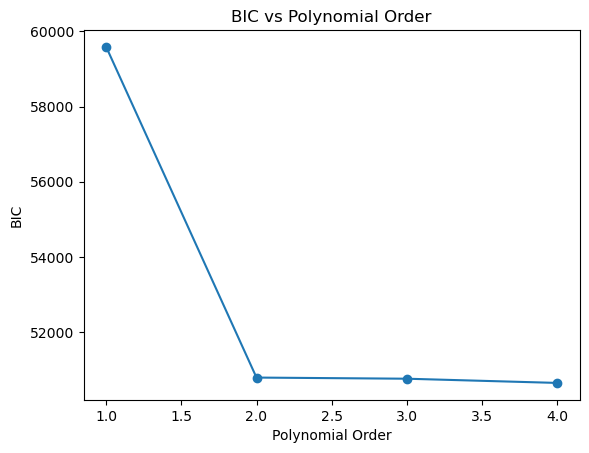

Spectrum 12: Best polynomial order = 2
Order 1: BIC = 59011.50
Order 2: BIC = 49747.93
Order 3: BIC = 49308.59
Order 4: BIC = 48950.22
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


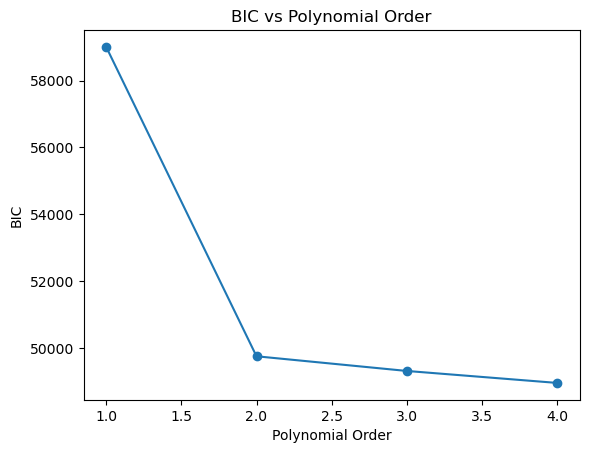

Spectrum 13: Best polynomial order = 2
Order 1: BIC = 59126.24
Order 2: BIC = 50317.23
Order 3: BIC = 50284.21
Order 4: BIC = 50175.53
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


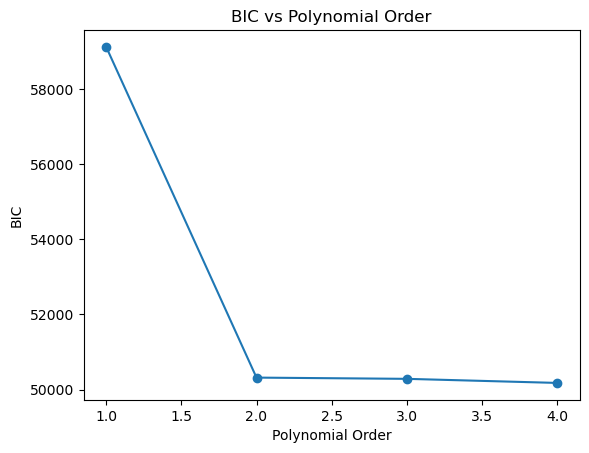

Spectrum 14: Best polynomial order = 2
Order 1: BIC = 58615.69
Order 2: BIC = 49424.34
Order 3: BIC = 48938.99
Order 4: BIC = 48601.74
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


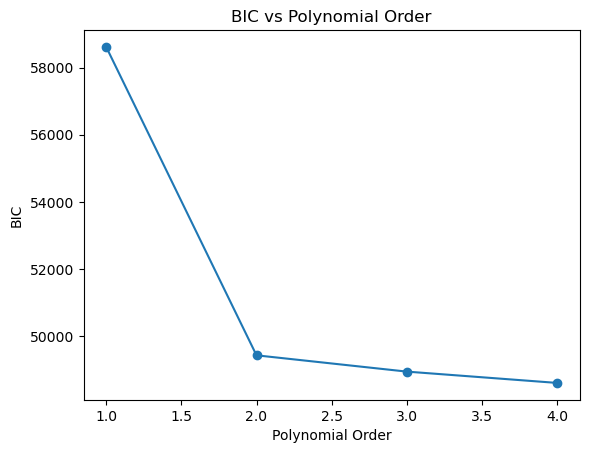

Spectrum 15: Best polynomial order = 2
Order 1: BIC = 58889.12
Order 2: BIC = 50071.75
Order 3: BIC = 50032.09
Order 4: BIC = 49918.94
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


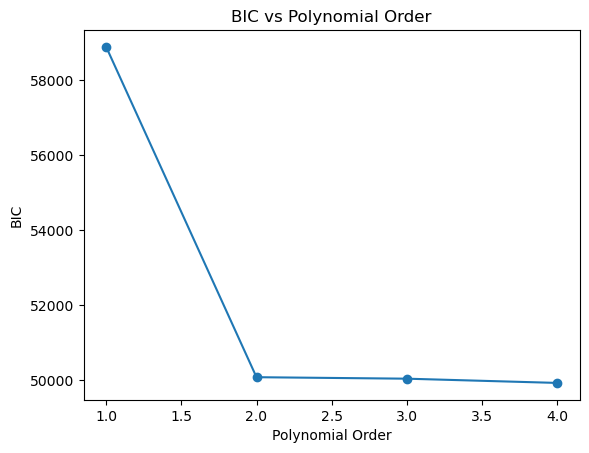

Spectrum 16: Best polynomial order = 2
Order 1: BIC = 59142.83
Order 2: BIC = 49803.64
Order 3: BIC = 49278.23
Order 4: BIC = 48930.44
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


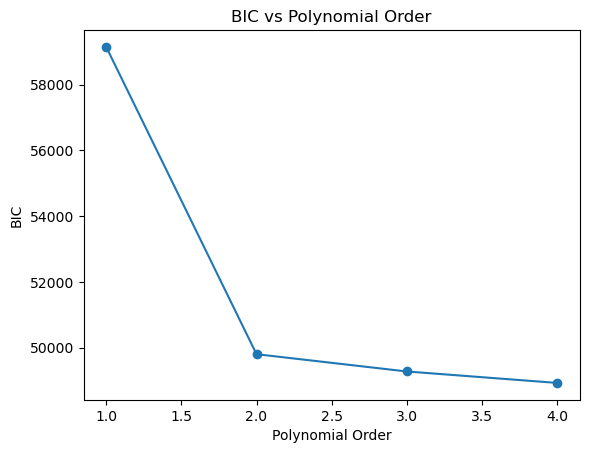

Spectrum 17: Best polynomial order = 2
Order 1: BIC = 59528.37
Order 2: BIC = 50532.50
Order 3: BIC = 50483.49
Order 4: BIC = 50357.53
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


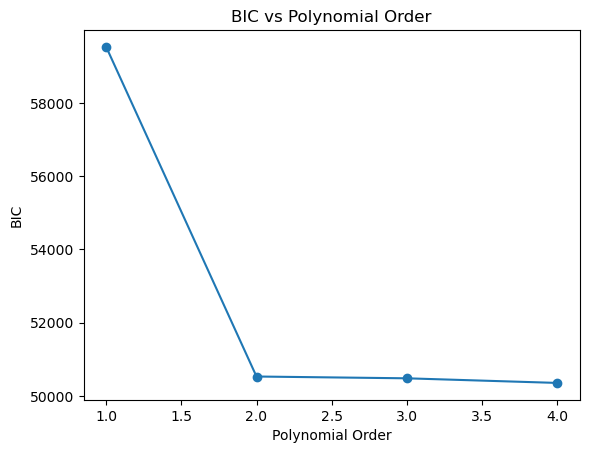

Spectrum 18: Best polynomial order = 2
Order 1: BIC = 59166.62
Order 2: BIC = 49789.40
Order 3: BIC = 49296.14
Order 4: BIC = 48942.74
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


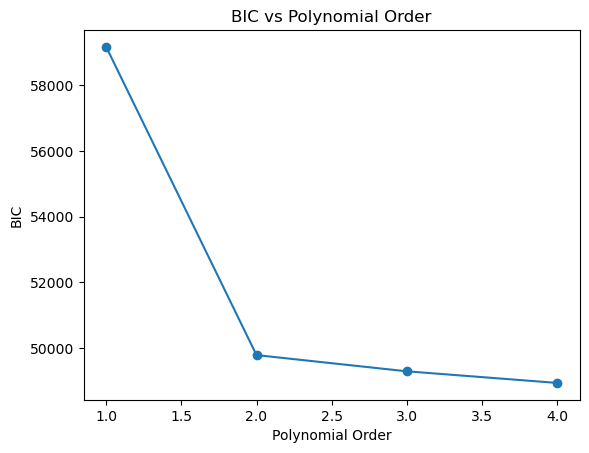

Spectrum 19: Best polynomial order = 2
Order 1: BIC = 59140.60
Order 2: BIC = 50130.76
Order 3: BIC = 50073.47
Order 4: BIC = 49936.52
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


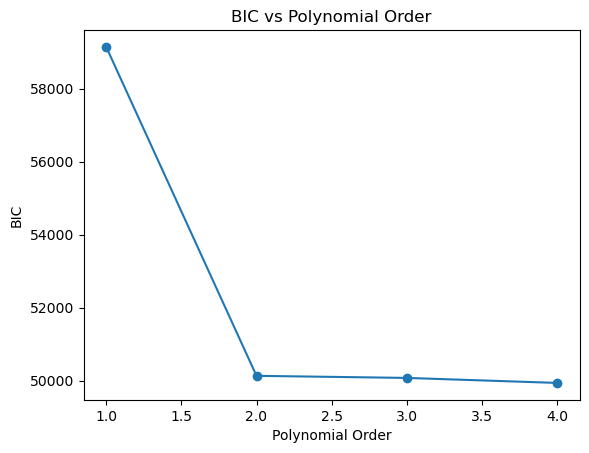

Spectrum 20: Best polynomial order = 2
Order 1: BIC = 59196.24
Order 2: BIC = 49913.98
Order 3: BIC = 49394.37
Order 4: BIC = 49024.27
Stopping early at order 4 after 2 consecutive non-improvements.
Selected best polynomial order by BIC: 2


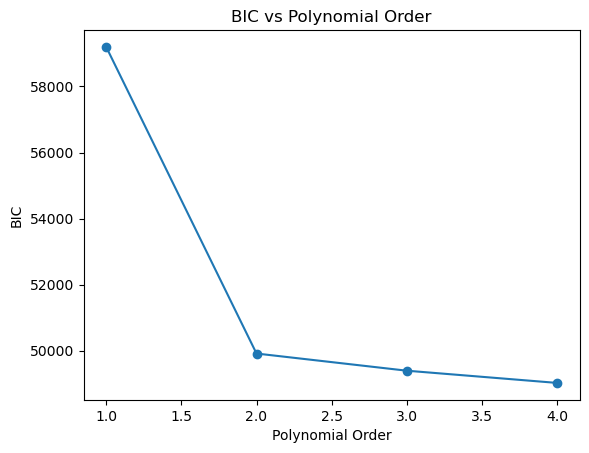

Spectrum 21: Best polynomial order = 2
Best order stats:
Mean order: 2.00
Median order: 2.0
Min order: 2
Max order: 2


In [5]:
ds = xr.open_dataset("blue_spectra_fixed.h5", engine="h5netcdf")
wavelength = ds['wavelength'].values
flux_array = ds['flux'].values  # shape: (time, wavelength)

num_spectra = flux_array.shape[0]
best_orders = []

exclude_regions = None

for i in range(num_spectra):
    flux = flux_array[i, :]
    flux_err = ds['flux_error'].values[i, :]
    
    best_order = patient_select_best_poly_order_bic(
        wavelength, flux, flux_error=flux_err,
        exclude_regions=exclude_regions,
        max_order=8,
        plot=False  # turn off plotting inside loop for speed
    )
    
    best_orders.append(best_order)
    print(f"Spectrum {i}: Best polynomial order = {best_order}")

# Optionally convert to numpy array for easy stats
best_orders = np.array(best_orders)

print("Best order stats:")
print(f"Mean order: {best_orders.mean():.2f}")
print(f"Median order: {np.median(best_orders)}")
print(f"Min order: {best_orders.min()}")
print(f"Max order: {best_orders.max()}")


In [20]:
def gaussian_absorption(x, amp, center, sigma, offset):
    return offset - amp * np.exp(-(x - center)**2 / (2 * sigma**2))

def voigt_absorption(x, amp, center, sigma, gamma, offset):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    voigt_prof = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    voigt_norm = voigt_prof / np.max(voigt_prof)
    return offset - amp * voigt_norm

def normalize_continuum(wavelength, flux, flux_error=None, poly_order=2, exclude_regions=None, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    if exclude_regions is not None:
        for region in exclude_regions:
            mask &= ~((wavelength > region[0]) & (wavelength < region[1]))

    poly_coeffs = np.polyfit(wavelength[mask], flux[mask], deg=poly_order)
    continuum = np.polyval(poly_coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    if plot:
        # Plot normalization
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        if exclude_regions is not None:
            for region in exclude_regions:
                plt.axvspan(region[0], region[1], color='red', alpha=0.2)
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()

    return norm_flux, norm_flux_error, continuum

def fit_centroid_compare(wavelength, flux, flux_error=None, lambda_0=None, w1=None, w2=None, line_name=None, plot=False):
    exclude_regions = [
    (3865, 3930),   # H + K
    (4060, 4140),   # Hδ
    (4290, 4407),   # Hγ
    (4790, 4900),   # Hβ (shortened)
]

    norm_flux, norm_flux_error, continuum = normalize_continuum(
        wavelength, flux, flux_error=flux_error, poly_order=3, exclude_regions=exclude_regions, plot=False
    )
    mask = (wavelength > w1) & (wavelength < w2)
    x = wavelength[mask]
    y = norm_flux[mask]
    yerr = norm_flux_error[mask] if flux_error is not None else None

    # Smooth for center guess
    from scipy.ndimage import gaussian_filter1d
    y_smoothed = gaussian_filter1d(y, sigma=2)
    center_guess = x[np.argmin(y_smoothed)]

    offset_guess = np.median(y[(x < center_guess - 1.5) | (x > center_guess + 1.5)])
    amp_guess = offset_guess - np.min(y)
    sigma_guess = 30.0
    gamma_guess = 2.0

    # Gaussian initial parameters and bounds
    p0_gauss = [amp_guess, center_guess, sigma_guess, offset_guess]
    lower_gauss = [0.0, center_guess - 5.0, 25.0, offset_guess - 1.0]
    upper_gauss = [offset_guess * 1.1, center_guess + 5.0, 35.0, offset_guess + 1.0]

    # Voigt initial parameters and bounds
    p0_voigt = [amp_guess, center_guess, sigma_guess, gamma_guess, offset_guess]
    lower_voigt = [0.0, center_guess - 5.0, 25.0, 0.1, offset_guess - 1.0]
    upper_voigt = [offset_guess * 1.1, center_guess + 5.0, 35.0, 10.0, offset_guess + 1.0]

    # Adjust errors in core if desired
    yerr_mod = yerr.copy() if yerr is not None else None
    if yerr_mod is not None:
        core = (x > center_guess - 1.0) & (x < center_guess + 1.0)
        yerr_mod[core] *= 1.5  # reduce influence of core

    # Fit Gaussian
    try:
        popt_gauss, pcov_gauss = curve_fit(
            gaussian_absorption, x, y, p0=p0_gauss, bounds=(lower_gauss, upper_gauss), sigma=yerr_mod, absolute_sigma=True if yerr_mod is not None else False
        )
        residuals_gauss = (y - gaussian_absorption(x, *popt_gauss)) / (yerr_mod if yerr_mod is not None else 1)
        ssr_gauss = np.sum(residuals_gauss**2)
        k_gauss = len(popt_gauss)
    except Exception as e:
        print(f"Gaussian fit failed: {e}")
        popt_gauss = None
        ssr_gauss = np.inf
        k_gauss = 0

    # Fit Voigt
    try:
        popt_voigt, pcov_voigt = curve_fit(
            voigt_absorption, x, y, p0=p0_voigt, bounds=(lower_voigt, upper_voigt), sigma=yerr_mod, absolute_sigma=True if yerr_mod is not None else False
        )
        residuals_voigt = (y - voigt_absorption(x, *popt_voigt)) / (yerr_mod if yerr_mod is not None else 1)
        ssr_voigt = np.sum(residuals_voigt**2)
        k_voigt = len(popt_voigt)
    except Exception as e:
        print(f"Voigt fit failed: {e}")
        popt_voigt = None
        ssr_voigt = np.inf
        k_voigt = 0

    N = len(x)
    bic_gauss = calculate_bic(ssr_gauss, N, k_gauss) if k_gauss > 0 else np.inf
    bic_voigt = calculate_bic(ssr_voigt, N, k_voigt) if k_voigt > 0 else np.inf

    print(f"Gaussian fit BIC: {bic_gauss:.2f}")
    print(f"Voigt fit BIC: {bic_voigt:.2f}")

    if bic_voigt < bic_gauss:
        best_model = 'Voigt'
        best_popt = popt_voigt
        best_func = voigt_absorption
        best_pcov = pcov_voigt
    else:
        best_model = 'Gaussian'
        best_popt = popt_gauss
        best_func = gaussian_absorption
        best_pcov = pcov_gauss

    print(f"Best fit model: {best_model}")

    # Calculate center and velocity if lambda_0 provided
    if best_popt is not None and lambda_0 is not None:
        center = best_popt[1]
        center_err = sqrt(best_pcov[1, 1]) if best_pcov is not None else np.nan
        velocity = 3e5 * (center - lambda_0) / lambda_0
        velocity_err = 3e5 * center_err / lambda_0
    else:
        center = center_err = velocity = velocity_err = np.nan

    # Optional plot
    if plot and best_popt is not None:
        plt.figure(figsize=(10, 5))
        plt.errorbar(x, y, yerr=yerr, fmt='k.', ecolor='gray', capsize=2, label='Observed Spectrum')
        plt.plot(x, best_func(x, *best_popt), 'r-', label=f'{best_model} Fit')
        plt.axvline(lambda_0, color='blue', linestyle=':', label=f'Reference: {lambda_0:.2f} Å')
        plt.axvline(best_popt[1], color='red', linestyle='--', label=f'Fit Center: {best_popt[1]:.2f} Å')
        plt.title(f"{line_name} - Best Fit: {best_model}")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Normalized Flux")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "best_model": best_model,
        "fit_params": best_popt,
        "fit_covariance": best_pcov,
        "center": center,
        "center_err": center_err,
        "velocity": velocity,
        "velocity_err": velocity_err,
        "bic_gauss": bic_gauss,
        "bic_voigt": bic_voigt,
    }


Gaussian fit BIC: 515.76
Voigt fit BIC: 500.61
Best fit model: Voigt
Spectrum 0: Best model = Voigt, Velocity = 182.15 km/s
Gaussian fit BIC: 284.49
Voigt fit BIC: 267.42
Best fit model: Voigt
Spectrum 1: Best model = Voigt, Velocity = 247.01 km/s
Gaussian fit BIC: 364.81
Voigt fit BIC: 345.99
Best fit model: Voigt
Spectrum 2: Best model = Voigt, Velocity = 190.02 km/s
Gaussian fit BIC: 275.13
Voigt fit BIC: 254.48
Best fit model: Voigt
Spectrum 3: Best model = Voigt, Velocity = 218.79 km/s
Gaussian fit BIC: 328.70
Voigt fit BIC: 306.44
Best fit model: Voigt
Spectrum 4: Best model = Voigt, Velocity = 169.48 km/s
Gaussian fit BIC: 277.72
Voigt fit BIC: 264.09
Best fit model: Voigt
Spectrum 5: Best model = Voigt, Velocity = 196.32 km/s
Gaussian fit BIC: 251.62
Voigt fit BIC: 234.04
Best fit model: Voigt
Spectrum 6: Best model = Voigt, Velocity = 139.80 km/s
Gaussian fit BIC: 184.56
Voigt fit BIC: 171.18
Best fit model: Voigt
Spectrum 7: Best model = Voigt, Velocity = 138.63 km/s
Gaussian

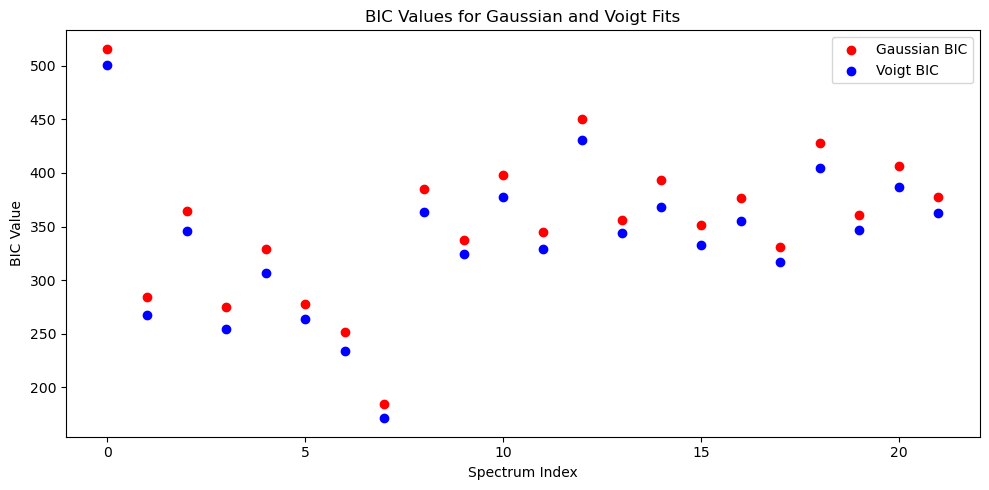

In [21]:
ds = xr.open_dataset("blue_spectra_fixed.h5", engine="h5netcdf")
wavelength = ds['wavelength'].values
flux_array = ds['flux'].values  # shape: (time, wavelength)
flux_error_array = ds['flux_error'].values 

num_spectra = flux_array.shape[0]

best_models = []
centers = []
velocities = []
bic_gaussians = []
bic_voigts = []

for i in range(num_spectra):
    flux = flux_array[i, :]
    flux_err = flux_error_array[i, :]

    # Example for Hα: Adjust w1, w2, and lambda_0 as needed
    result = fit_centroid_compare(
        wavelength=wavelength,
        flux=flux,
        flux_error=flux_err,
        lambda_0=4861.3,
        w1=4800,
        w2=5000,
        line_name=f"Spectrum {i}",
        plot=False  # disable plots in loops for speed
    )

    # Store results
    best_models.append(result["best_model"])
    centers.append(result["center"])
    velocities.append(result["velocity"])
    bic_gaussians.append(result["bic_gauss"])
    bic_voigts.append(result["bic_voigt"])

    print(f"Spectrum {i}: Best model = {result['best_model']}, Velocity = {result['velocity']:.2f} km/s")

# Optionally convert to numpy arrays
best_models = np.array(best_models)
centers = np.array(centers)
velocities = np.array(velocities)
bic_gaussians = np.array(bic_gaussians)
bic_voigts = np.array(bic_voigts)

# Example summary stats
print("\nModel summary:")
print(f"Gaussian fits: {(best_models == 'Gaussian').sum()}/{num_spectra}")
print(f"Voigt fits: {(best_models == 'Voigt').sum()}/{num_spectra}")

print("\nVelocity stats:")
print(f"Mean velocity: {np.nanmean(velocities):.2f} km/s")
print(f"Min velocity: {np.nanmin(velocities):.2f} km/s")
print(f"Max velocity: {np.nanmax(velocities):.2f} km/s")

plt.figure(figsize=(10, 5))
plt.scatter(range(len(bic_gaussians)), bic_gaussians, label='Gaussian BIC', color='red', marker='o')
plt.scatter(range(len(bic_voigts)), bic_voigts, label='Voigt BIC', color='blue', marker='o')

plt.xlabel('Spectrum Index')
plt.ylabel('BIC Value')
plt.title('BIC Values for Gaussian and Voigt Fits')
plt.legend()
plt.tight_layout()
plt.show()



In [2]:
def gaussian_absorption(x, amp, center, sigma, offset):
    return offset - amp * np.exp(-(x - center)**2 / (2 * sigma**2))

def voigt_absorption(x, amp, center, sigma, gamma, offset):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    voigt_prof = np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))
    voigt_norm = voigt_prof / np.max(voigt_prof)
    return offset - amp * voigt_norm

In [3]:
# Define the calculate_bic function
def calculate_bic(ssr, N, k):
    """
    Calculates the Bayesian Information Criterion (BIC).

    Parameters:
    ssr (float): Sum of Squared Residuals.
    N (int): Number of data points used in the fit.
    k (int): Number of parameters in the model.

    Returns:
    float: The BIC value.
    """
    if N == 0: # Handle cases where no points are left after masking
        return np.inf
    return N * np.log(ssr / N) + k * np.log(N)

# --- MODIFIED iterative_polyfit FUNCTION ---
def iterative_polyfit(wavelength, flux, flux_error=None, degree=3, sigma=2, max_iter=5, plot=False):
    mask = np.ones_like(wavelength, dtype=bool)
    for _ in range(max_iter):
        coeffs = np.polyfit(wavelength[mask], flux[mask], degree)
        model = np.polyval(coeffs, wavelength)
        residuals = flux - model
        std = np.std(residuals[mask])
        mask &= np.abs(residuals) < sigma * std

    continuum = np.polyval(coeffs, wavelength)
    norm_flux = flux / continuum
    norm_flux_error = flux_error / continuum if flux_error is not None else None

    # Calculate SSR (Sum of Squared Residuals) for the final masked points
    final_residuals = flux[mask] - np.polyval(coeffs, wavelength[mask])
    ssr = np.sum(final_residuals**2)

    if plot:
        plt.figure()
        plt.plot(wavelength, flux, label="Original Flux")
        plt.plot(wavelength, continuum, label="Fitted Continuum", linestyle="--")
        plt.legend()
        plt.title("Continuum Normalization")
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.tight_layout()
        plt.show()

    # Return mask and ssr in addition to original returns
    return norm_flux, norm_flux_error, continuum, mask, ssr

In [10]:
# --- MODIFIED patient_select_best_poly_order_bic FUNCTION ---
def patient_select_best_poly_order_bic(wavelength, flux, flux_error=None, w1=None, w2=None, plot=False, min_bic_improvement=1000, patience=2):
    """
    Selects the best polynomial order for localized continuum normalization using iterative_polyfit and BIC.

    Args:
        wavelength (np.array): Array of wavelengths.
        flux (np.array): Array of flux values.
        flux_error (np.array, optional): Array of flux errors. Defaults to None.
        w1 (float): Start wavelength of the local region.
        w2 (float): End wavelength of the local region.
        max_order (int, optional): Maximum polynomial order to test. Defaults to 8.
        plot (bool, optional): Whether to plot the final best continuum fit. Defaults to False.
        min_bic_improvement (int, optional): Minimum BIC improvement to consider a step "better". Defaults to 1000.
        patience (int, optional): Number of consecutive non-improving steps to stop early. Defaults to 2.

    Returns:
        int: The selected best polynomial order.
    """
    
    if w1 is None or w2 is None:
        raise ValueError("w1 and w2 must be provided for localized normalization.")

    # 1. Localize the data based on w1 and w2
    local_mask = (wavelength >= w1) & (wavelength <= w2) # Use >= and <= for inclusive range
    wavelength_local = wavelength[local_mask]
    flux_local = flux[local_mask]
    flux_error_local = flux_error[local_mask] if flux_error is not None else None
    max_order=min(len(wavelength_local) - 2, 3)
    bics = []
    orders = list(range(1, max_order + 1)) # Start from order 1 for polynomial fitting

    best_order = 1
    best_bic = np.inf
    bad_steps = 0  # counts how many consecutive steps without improvement

    print(f"Starting BIC selection for local region {w1}-{w2} Å.")
    
    for order in orders:
        if len(wavelength_local) < order + 2: # Need at least order+2 points for polyfit
            print(f"Skipping order {order}: Not enough data points ({len(wavelength_local)}) in local region.")
            bics.append(np.inf) # Mark as invalid
            continue

        # Call the modified iterative_polyfit on the localized data
        # Use the empirically determined good sigma and max_iter
        _, _, _, final_mask, ssr = iterative_polyfit(
            wavelength_local, flux_local, flux_error=flux_error_local,
            degree=order,
            sigma=1, # Use the refined sigma from previous discussions
            max_iter=10, # Use the refined max_iter
            plot=False # Do not plot during intermediate BIC calculations
        )

        N = np.sum(final_mask) # N is the number of data points used in the final fit
        if N == 0: # Ensure N is not zero if all points were masked out
            print(f"Order {order}: No data points remained after masking. BIC = inf.")
            bics.append(np.inf)
            continue

        k = order + 1 # Number of parameters in polynomial fit (degree + 1)
        bic = calculate_bic(ssr, N, k)
        bics.append(bic)

        print(f"Order {order}: BIC = {bic:.2f}, N = {N}")

        # BIC improvement logic
        if bic < best_bic - min_bic_improvement:
            best_bic = bic
            best_order = order
            bad_steps = 0  # reset patience counter
        else:
            bad_steps += 1

        if bad_steps >= patience:
            print(f"Stopping early at order {order} after {patience} consecutive non-improvements (min_bic_improvement={min_bic_improvement}).")
            break

    # Plot final continuum using the best_order if requested
    if plot:
        print(f"\nPlotting final continuum for best order: {best_order}")
        iterative_polyfit(
            wavelength_local, flux_local, flux_error=flux_error_local,
            degree=best_order,
            sigma=1,
            max_iter=10,
            plot=True # Plot the final best fit here
        )

    print(f"\nSelected best polynomial order by BIC for local region {w1}-{w2} Å: {best_order}")

    plt.figure(figsize=(8, 5))
    plt.plot(orders[:len(bics)], bics, marker='o', linestyle='-', color='blue')
    plt.xlabel('Polynomial Order')
    plt.ylabel('BIC')
    plt.title(f'BIC vs Polynomial Order for Local Region {w1}-{w2} Å')
    plt.grid(True)
    plt.xticks(orders[:len(bics)])
    plt.show()

    return best_order

Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -18.18, N = 7
Order 2: No data points remained after masking. BIC = inf.
Order 3: BIC = -31.13, N = 8

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


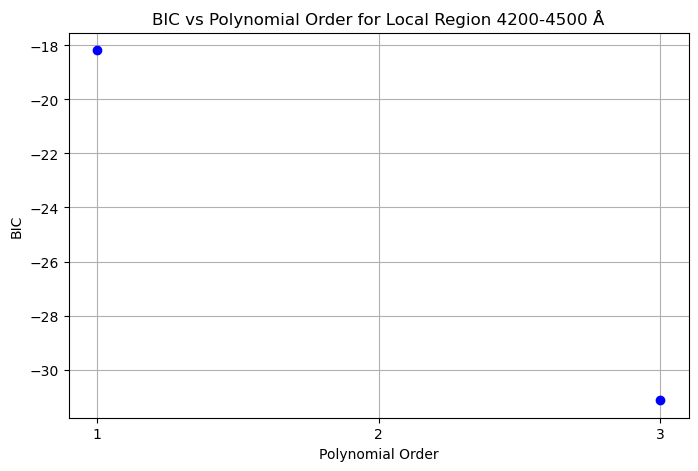

Spectrum 0: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -12.30, N = 8
Order 2: BIC = -4.89, N = 2
Order 3: BIC = -7.69, N = 3
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


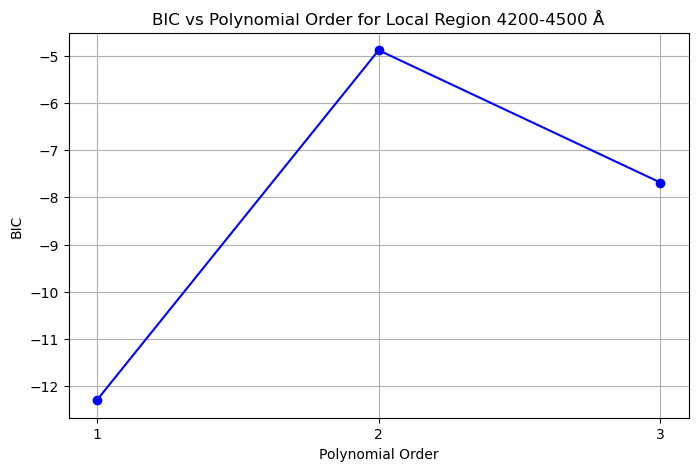

Spectrum 1: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -9.82, N = 5
Order 2: BIC = -18.41, N = 8
Order 3: BIC = -12.81, N = 5
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


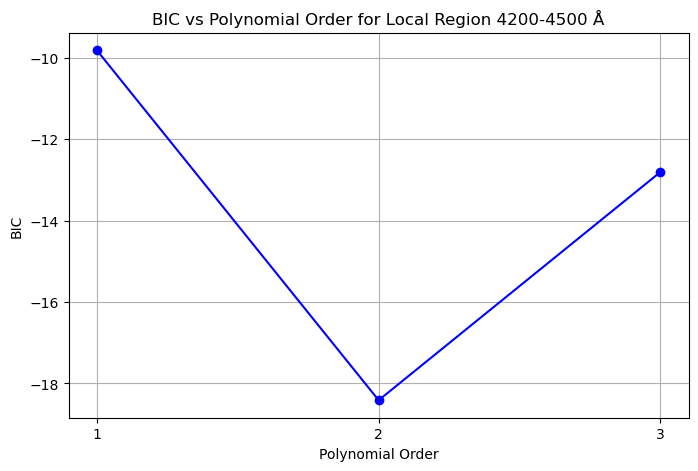

Spectrum 2: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -15.90, N = 7
Order 2: BIC = -16.61, N = 5
Order 3: BIC = -14.21, N = 4
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


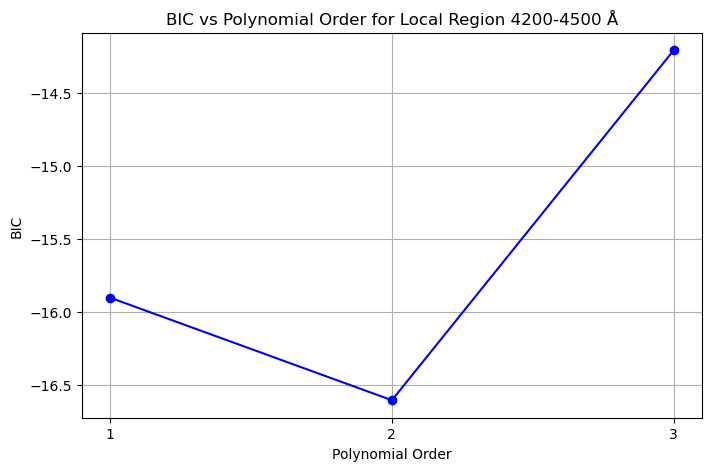

Spectrum 3: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -4.14, N = 6
Order 2: BIC = -10.37, N = 5
Order 3: BIC = -15.62, N = 5

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


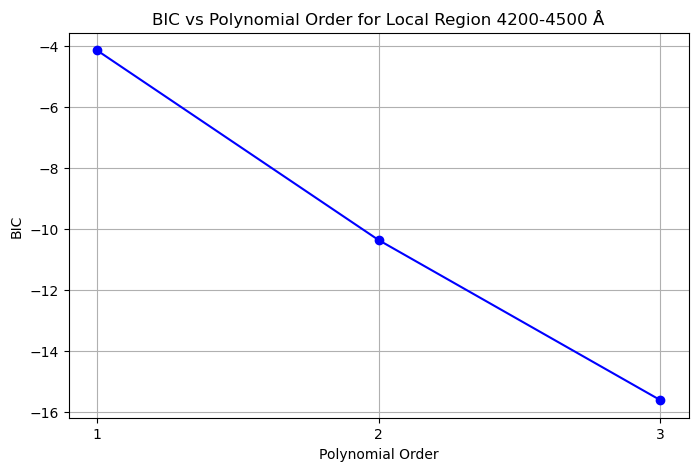

Spectrum 4: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -6.46, N = 7
Order 2: BIC = -29.81, N = 8
Order 3: BIC = -18.48, N = 6

Selected best polynomial order by BIC for local region 4200-4500 Å: 2


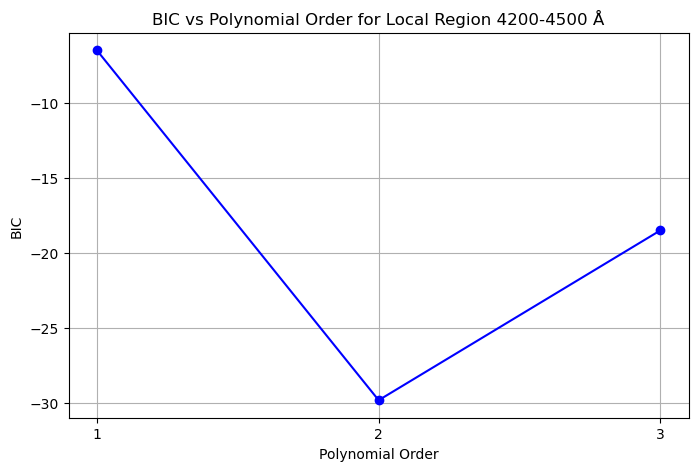

Spectrum 5: Best polynomial order = 2
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -8.97, N = 6
Order 2: BIC = -29.13, N = 7
Order 3: BIC = -9.92, N = 5

Selected best polynomial order by BIC for local region 4200-4500 Å: 2


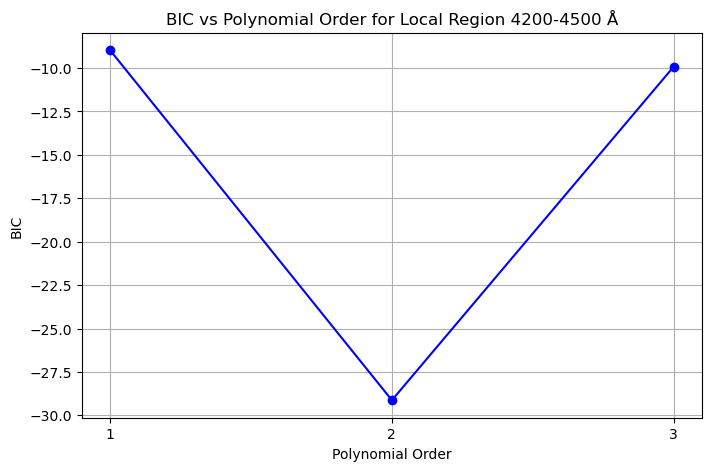

Spectrum 6: Best polynomial order = 2
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -10.45, N = 7
Order 2: BIC = -10.87, N = 3
Order 3: BIC = -17.25, N = 5
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


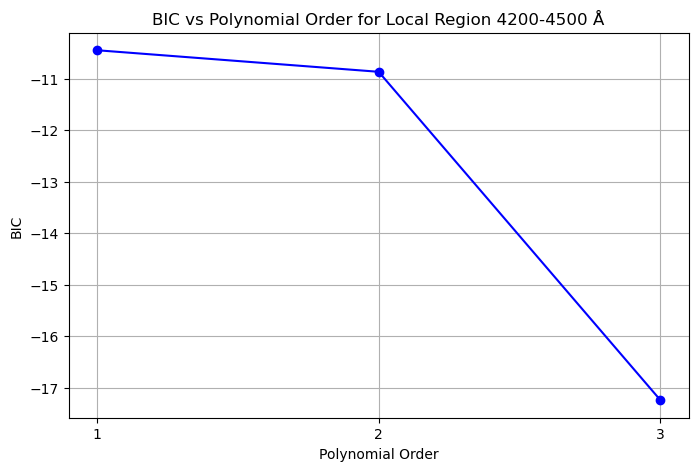

Spectrum 7: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -17.20, N = 9
Order 2: BIC = -13.96, N = 6
Order 3: BIC = -27.84, N = 8

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


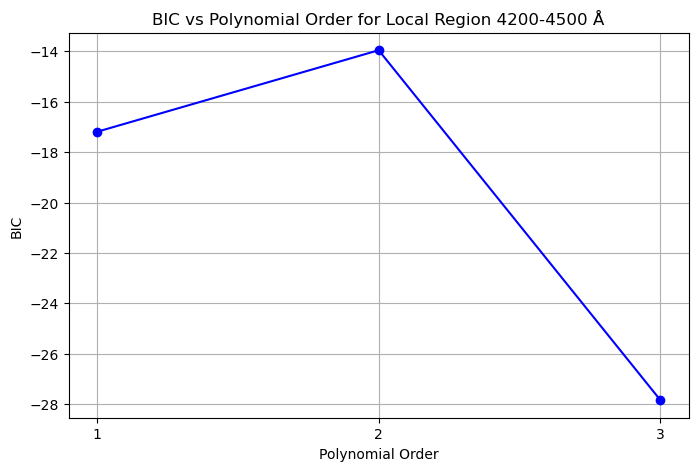

Spectrum 8: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -20.17, N = 5
Order 2: BIC = -4.06, N = 3
Order 3: BIC = -16.85, N = 7
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


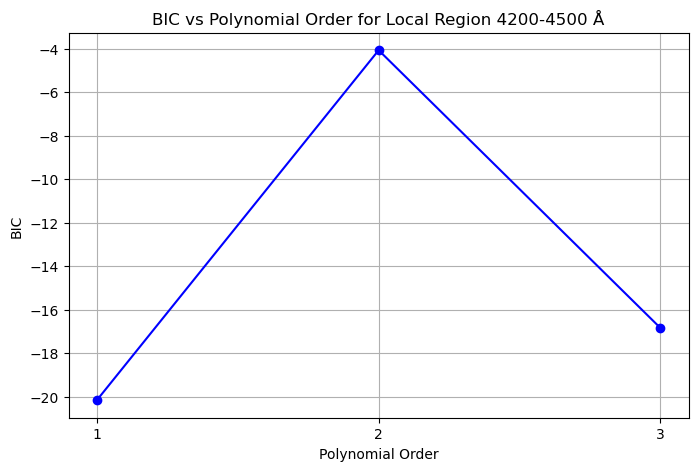

Spectrum 9: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -7.89, N = 6
Order 2: BIC = -16.29, N = 5
Order 3: BIC = -20.24, N = 7

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


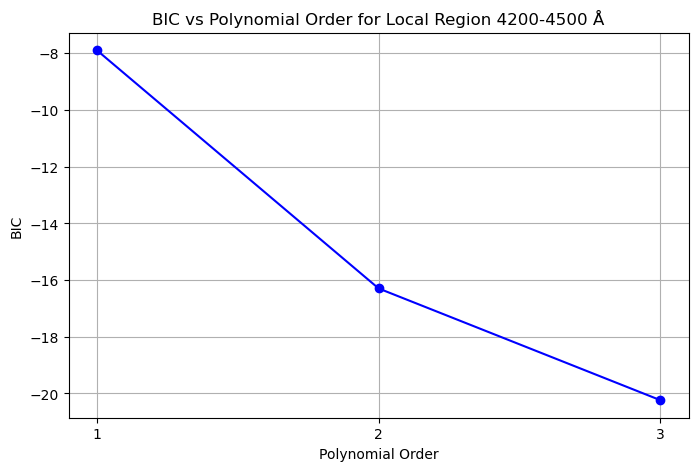

Spectrum 10: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -2.24, N = 8
Order 2: BIC = -9.40, N = 7
Order 3: BIC = -15.32, N = 7

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


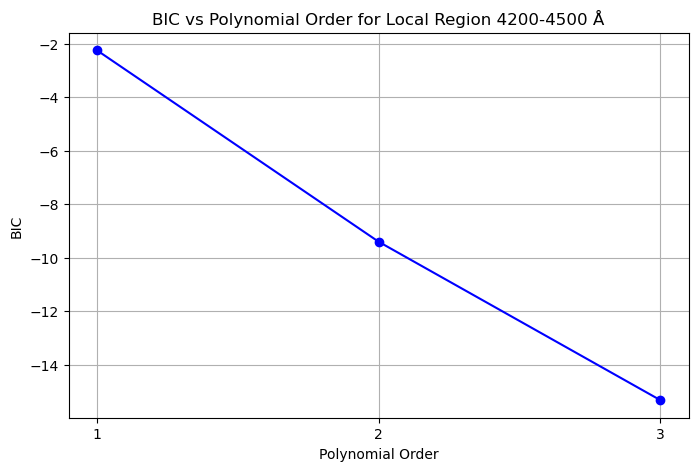

Spectrum 11: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -17.76, N = 9
Order 2: BIC = -10.10, N = 3
Order 3: BIC = -12.79, N = 5
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


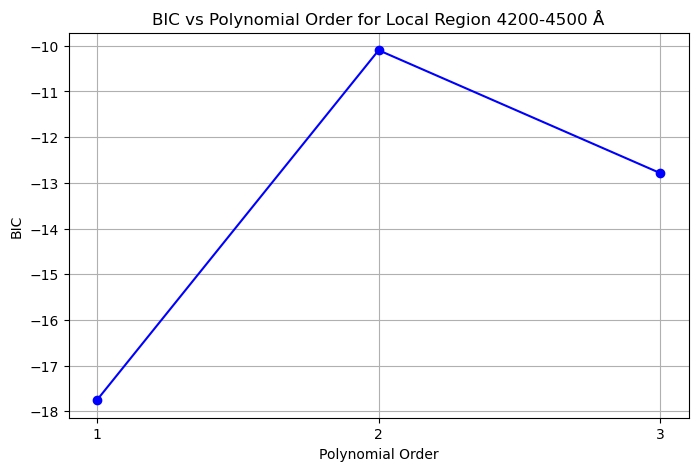

Spectrum 12: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -10.16, N = 6
Order 2: BIC = -12.89, N = 8
Order 3: BIC = -5.34, N = 3
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


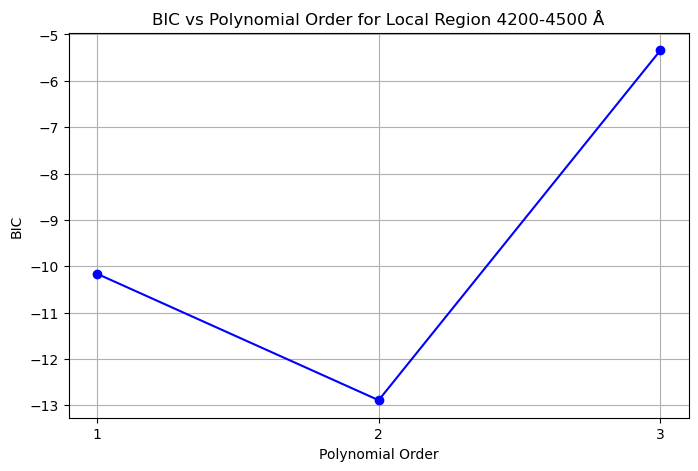

Spectrum 13: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -6.97, N = 4
Order 2: BIC = -4.77, N = 6
Order 3: BIC = -29.45, N = 5

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


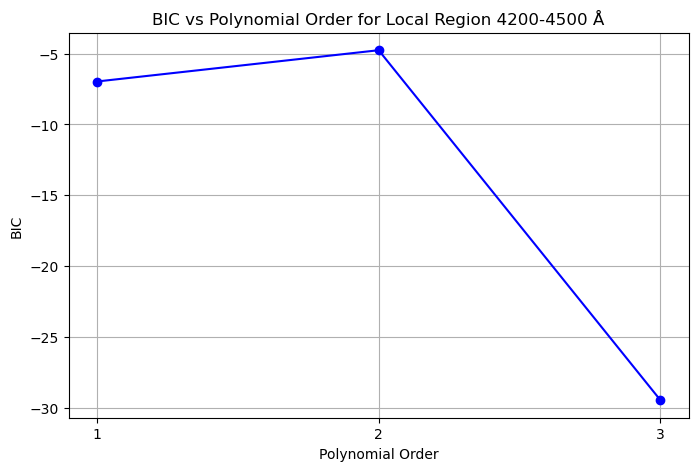

Spectrum 14: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -17.83, N = 7
Order 2: BIC = -29.73, N = 9
Order 3: BIC = -27.95, N = 9

Selected best polynomial order by BIC for local region 4200-4500 Å: 2


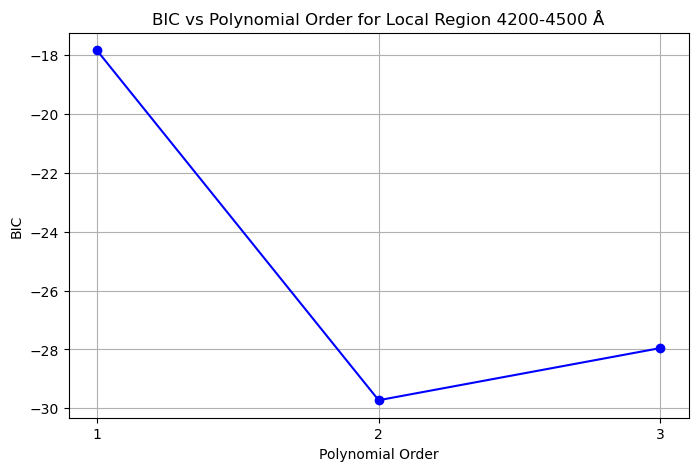

Spectrum 15: Best polynomial order = 2
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -13.10, N = 7
Order 2: BIC = -4.21, N = 5
Order 3: BIC = -21.39, N = 6
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


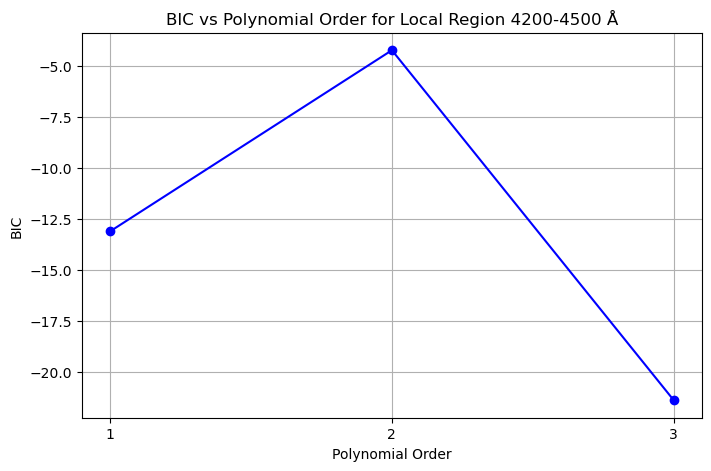

Spectrum 16: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -14.36, N = 8
Order 2: BIC = -18.51, N = 5
Order 3: BIC = -16.19, N = 8
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


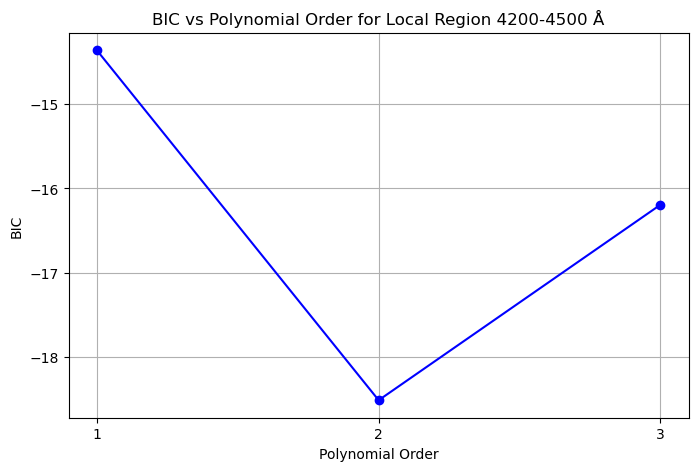

Spectrum 17: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -6.87, N = 6
Order 2: BIC = -19.75, N = 6
Order 3: BIC = -18.26, N = 4

Selected best polynomial order by BIC for local region 4200-4500 Å: 2


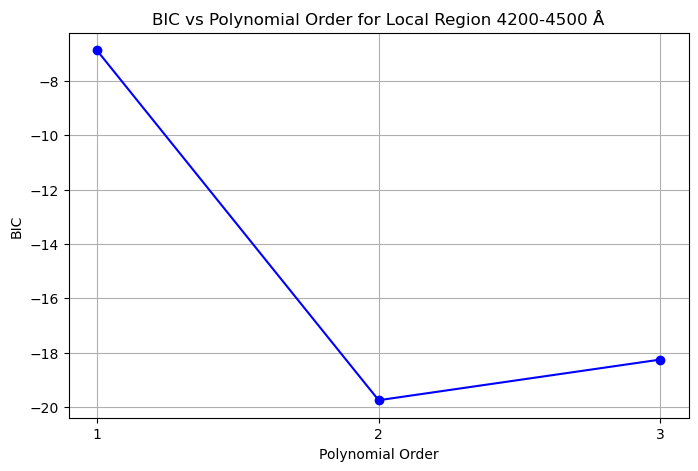

Spectrum 18: Best polynomial order = 2
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -10.35, N = 5
Order 2: BIC = -10.90, N = 5
Order 3: BIC = -11.13, N = 4
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


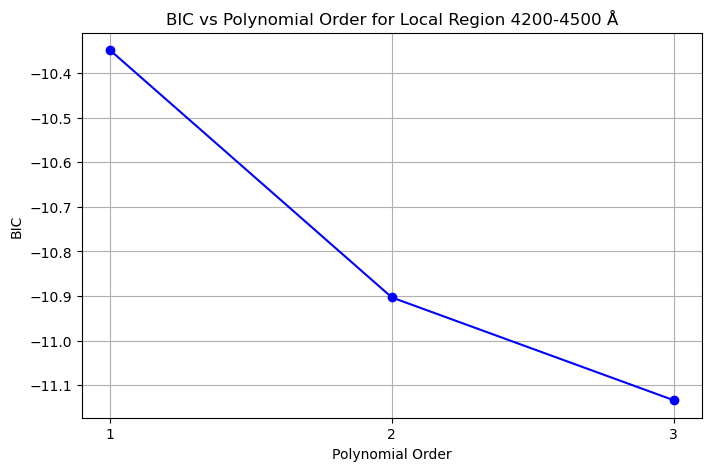

Spectrum 19: Best polynomial order = 1
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = 1.25, N = 6
Order 2: BIC = -7.18, N = 5
Order 3: BIC = -17.98, N = 4

Selected best polynomial order by BIC for local region 4200-4500 Å: 3


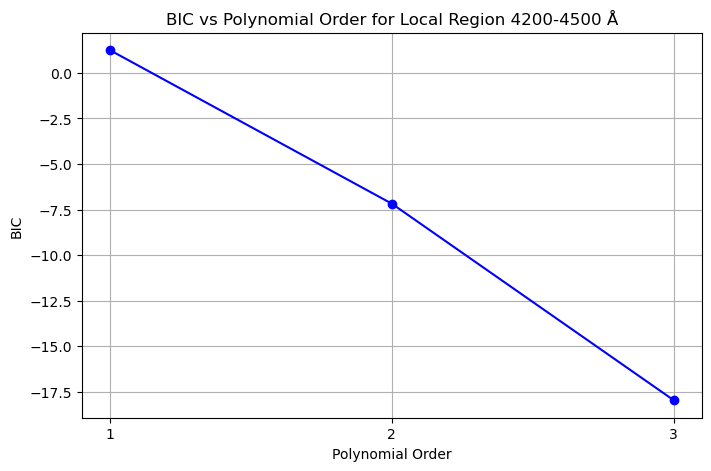

Spectrum 20: Best polynomial order = 3
Starting BIC selection for local region 4200-4500 Å.
Order 1: BIC = -6.53, N = 4
Order 2: BIC = -5.52, N = 3
Order 3: BIC = -12.43, N = 4
Stopping early at order 3 after 2 consecutive non-improvements (min_bic_improvement=10).

Selected best polynomial order by BIC for local region 4200-4500 Å: 1


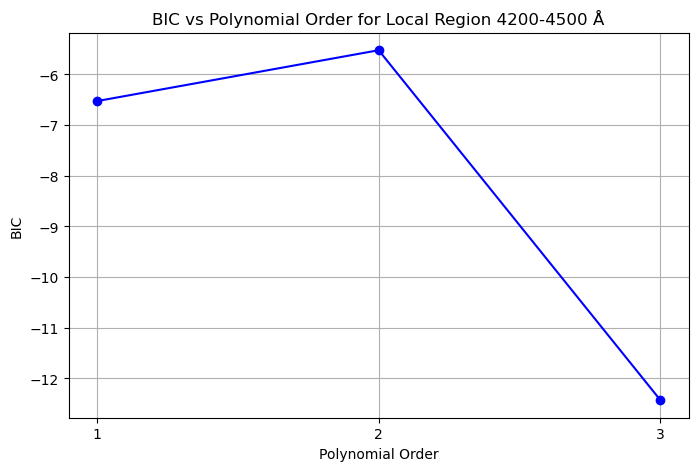

Spectrum 21: Best polynomial order = 1
Best order stats:
Mean order: 1.82
Median order: 1.5
Min order: 1
Max order: 3


In [11]:
ds = xr.open_dataset("blue_spectra_fixed.h5", engine="h5netcdf")
wavelength = ds['wavelength'].values
flux_array = ds['flux'].values  # shape: (time, wavelength)

num_spectra = flux_array.shape[0]
best_orders = []

exclude_regions = None

for i in range(num_spectra):
    flux = flux_array[i, :]
    flux_err = ds['flux_error'].values[i, :]
    
    best_order = patient_select_best_poly_order_bic(
        wavelength, flux, flux_error=flux_err,
        w1=4200, w2=4500,
        plot=False,  # turn off plotting inside loop for speed
        min_bic_improvement=10, 
        patience=2
    )

    best_orders.append(best_order)
    print(f"Spectrum {i}: Best polynomial order = {best_order}")

# Optionally convert to numpy array for easy stats
best_orders = np.array(best_orders)

print("Best order stats:")
print(f"Mean order: {best_orders.mean():.2f}")
print(f"Median order: {np.median(best_orders)}")
print(f"Min order: {best_orders.min()}")
print(f"Max order: {best_orders.max()}")